<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Ресемплинг" data-toc-modified-id="Ресемплинг-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплинг</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
import time

### Изучение данных

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [7]:
df.isna().sum()

num_orders    0
dtype: int64

In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


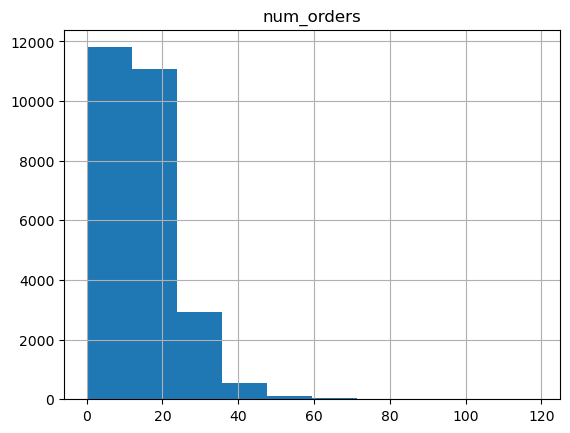

In [9]:
df.hist();

### Ресемплинг

Выполним ресемплирование по часу

In [10]:
df.sort_index(inplace = True)

In [11]:
df = df.resample('1H').sum()

<b>Вывод:</b> данные были загружены и изучены, дополнительная предобработка не потребовалась.

In [12]:
df['rolling_mean'] = df.rolling(10).mean() 

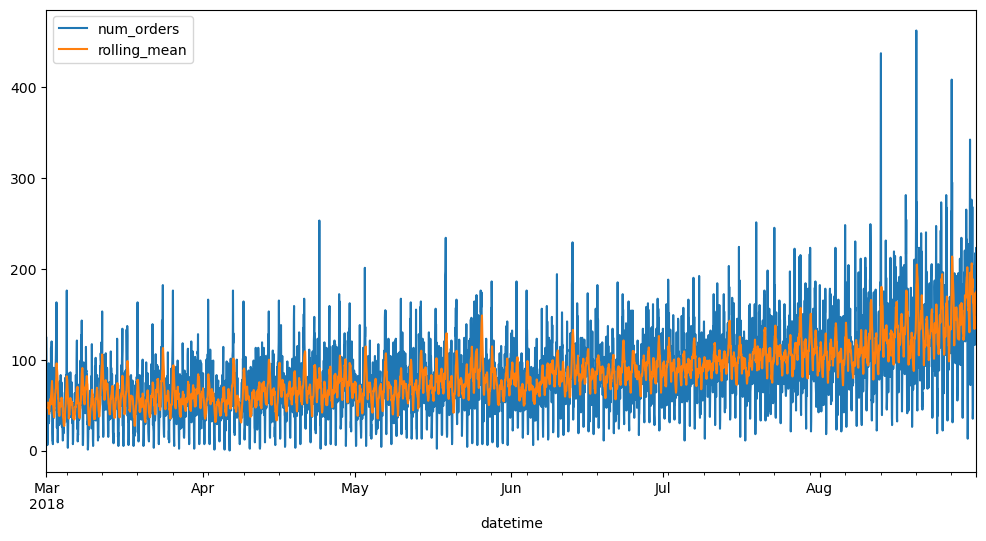

In [13]:
df.plot(figsize=(12,6));

## Анализ

Посмотрим на графики:

График тренда в полном размере:

In [14]:
#пришлось удалить столбец, т.к. иначе не строились графики
df = df.drop('rolling_mean', axis=1)

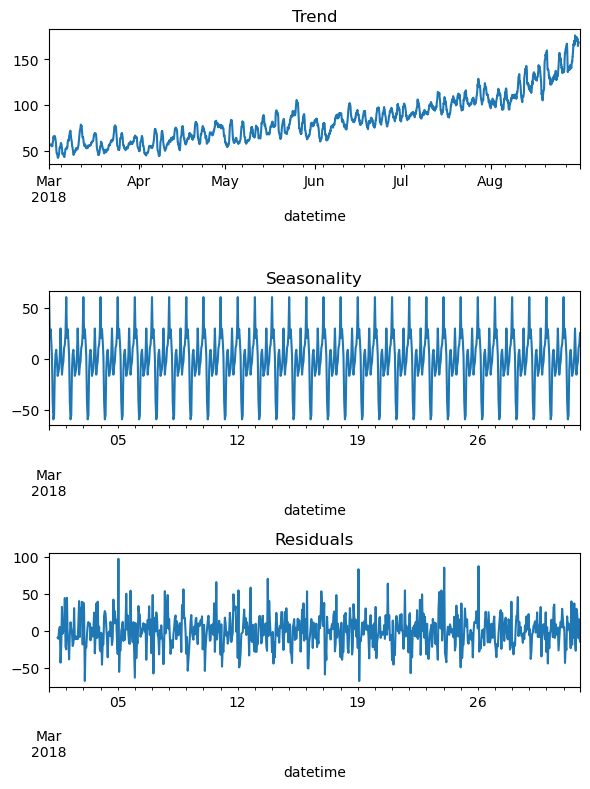

In [15]:
decomposed = seasonal_decompose(df) 
plt.figure(figsize =(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax = plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-31'].plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

<b>Вывод:</b> Если рассматривать график тренда, то можно заметить, что общее кол-во заказов такси растет. Причем под конец временного промежутка показатель значительно отличается от начала.

Напишем функцию для создания признаков:

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 48)

Разделим данные на выборки:

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [18]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3926, 27)
(3926,)
(442, 27)
(442,)


<b>Вывод: </b>были построены графики временных рядов для наглядности, созданы признаки с помощью функции и данные разделены на выборки.

## Обучение

Напишем ф-ию, которая ищет наилучшие параметры модели с использованием TimeSeriesSplit для временных рядов

In [19]:
def GSCV(model, parametrs):
    start = time.time()
    
    tscv = TimeSeriesSplit(n_splits = 2)
    grid = GridSearchCV(model,parametrs, scoring = 'neg_mean_squared_error',n_jobs = -1, cv = tscv)
    grid.fit(features_train, target_train)
    parametrs = grid.best_params_
    metrics = (max(grid.cv_results_['mean_test_score'] * -1 ) **.5)
    end = time.time()
    
    lead_time = (end - start) / 60
    
    return parametrs, metrics, lead_time

Из моделей возьмем случайный лес, LightGBM и CatBoost

<b>Случайный лес</b>

In [20]:
model_forest = RandomForestRegressor() 
parametrs = {'n_estimators': range(1,10, 2), 
    'max_depth': range(1,10,2), 
    'min_samples_split': range(2, 6, 2), 
    'random_state' : [12345] }
parametrs_forest, rmse_forest, lead_time_forest = GSCV(model_forest, parametrs) 
print('Лучшие параметры', parametrs_forest) 
print('RMSE:', {rmse_forest}) 
print('Время выполнения:', {lead_time_forest})

Лучшие параметры {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 9, 'random_state': 12345}
RMSE: {40.16202583848668}
Время выполнения: {0.08049577871958415}


<b>LightGBM</b>

In [21]:
model_lgbm = LGBMRegressor() 
parametrs = [{'learning_rate': [0.1, 0.2, 0.5, 0.8], 
    'max_depth': [4, 16], 
    'random_state' : [12345],}]
parametrs_lgbm, rmse_lgbm, lead_time_lgbm = GSCV(model_lgbm, parametrs) 
print('Лучшие параметры:', parametrs_lgbm) 
print('RMSE:', {rmse_lgbm}) 
print('Время выполнения:', {lead_time_lgbm})

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 4, 'random_state': 12345}
RMSE: {32.5583662506718}
Время выполнения: {0.03102104663848877}


<b>CatBoost</b>

In [22]:
warnings.filterwarnings("ignore")

In [21]:
model_cb = CatBoostRegressor()
parametrs = [{'learning_rate' : [0.2, 0.4, 0.5, 0.8],
    'random_state' : [12345],
    'max_depth' : [4, 8],
    'verbose': [False]}]

parametrs_cb, rmse_cb, lead_time_cb = GSCV(model_cb, parametrs)
print('Лучшие параметры:', parametrs_cb) 
print('RMSE:', rmse_cb) 
print('Время выполнения:', {lead_time_cb})
RMSE_Best = 32.91877456266668

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 4, 'random_state': 12345, 'verbose': False}
RMSE: 31.12190664634271
Время выполнения: {2.750337266921997}


Соберем в таблицу для наглядности:

In [24]:
new_df = {'Random_Forest_regressor': pd.Series([rmse_forest, lead_time_forest],
                                           index = ['RMSE', 'time']),
       'LGBMRegressor': pd.Series([rmse_lgbm, lead_time_lgbm],
                                           index = ['RMSE', 'time']),
       'CatBoost' : pd.Series([rmse_cb, lead_time_cb],
                                  index = ['RMSE', 'time'])
     }
new_df = pd.DataFrame(new_df)
new_df

,Random_Forest_regressor,LGBMRegressor,CatBoost
RMSE,40.162026,32.558366,31.121907
time,0.139640,0.056167,1.305735


<b>Вывод:</b> были обучены несколько моделей, наиболее подходящей оказалась модель CatBoostRegressor с показателями:

    Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 4, 'random_state': 12345, 'verbose': False}
    RMSE: 31.051011277519564
    Время выполнения: {1.2640093366305034}

## Тестирование

Т.к. лучшей моделью показал себя CatBoost - используем его для итогового тестирования

In [25]:
best_model = CatBoostRegressor(learning_rate = 0.2, max_depth = 4, random_state = 12345, verbose = False)
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)

In [26]:
print((mean_squared_error(target_test, predictions))**.5)

42.532197374046675


Итоговое значение RMSE = _42_, что меньше 48, значит обученная модель нам подходит и процесс был построен верно.

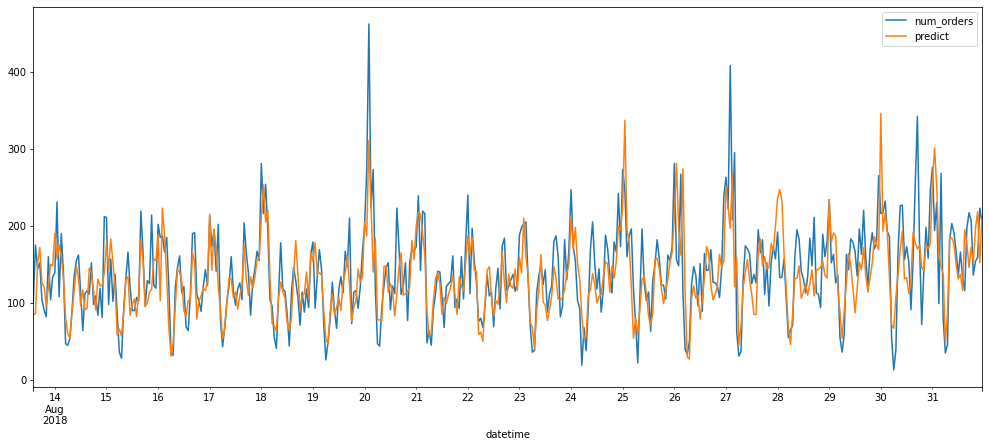

In [27]:
test['predict'] = predictions.astype(int)
fig, ax = plt.subplots()
test['num_orders'].plot(figsize=(17, 7), label='num_orders')
test['predict'].plot(label='predict');
ax.legend();

## Вывод

Загруженные данные были изучены и проанлизированы. Дополнительная предобработка не понадобилась. Для наглядности были построены графики временных рядов и написана функция для создания признаков.

Обучено было три модели: Random Forest, LightGBM и CatBoost. RMSE на трех моделях было равно: _40.1_, _32.5_, _31.1_ соотвественно. В связи с этим, для итогового тестирования была выбрана модель CatBoostRegressor со следующими параметрами:

    Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 4, 'random_state': 12345, 'verbose': False}
    RMSE: 31.051011277519564
    Время выполнения: {1.2640093366305034}
    
Итоговое значение RMSE на выбранной модели составило _42.5_, что, в нашем случае, является хорошим показателем и подходит по условию. 